In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 289 image(s) in /content/drive/MyDrive/final dataset/data_road_224/training/image_2


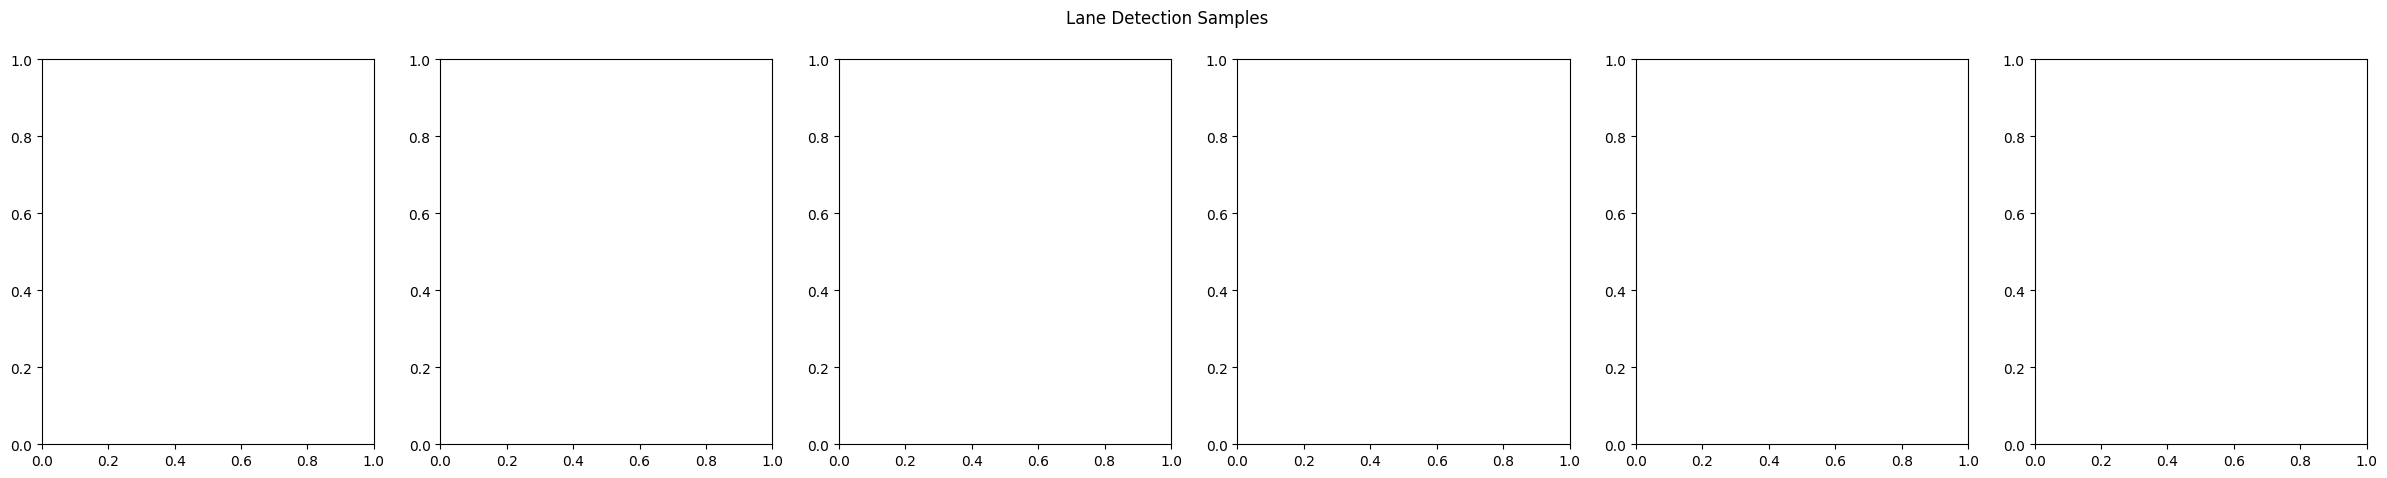

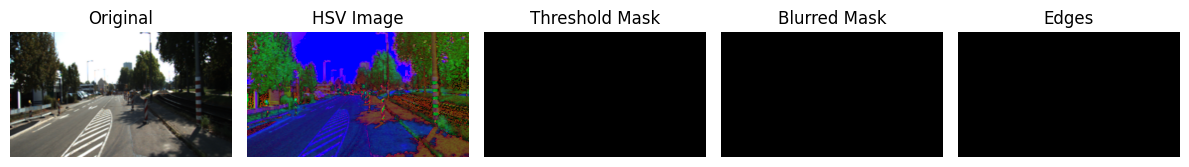

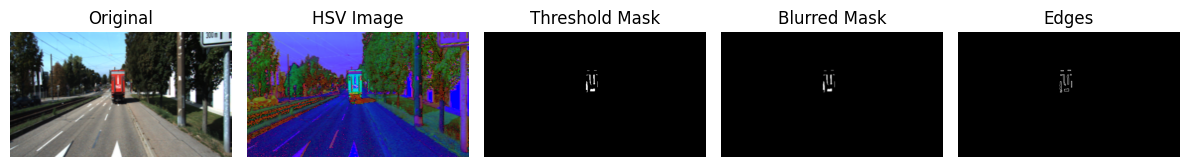

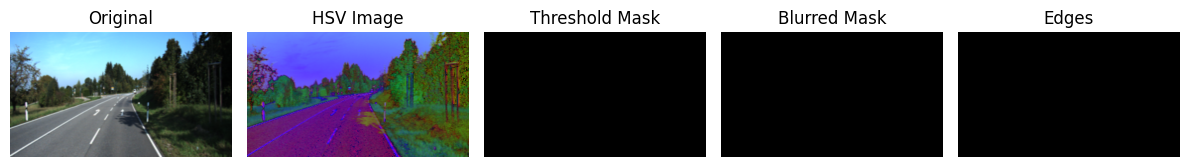

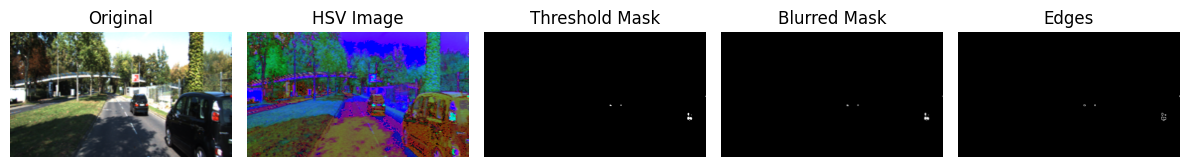

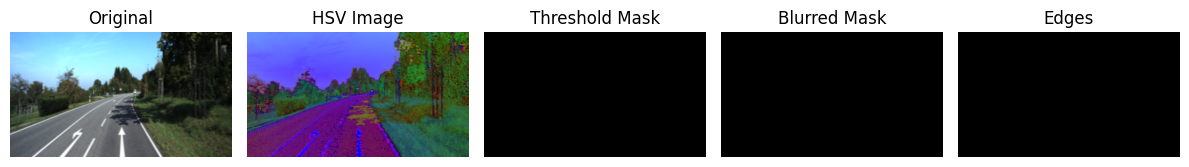

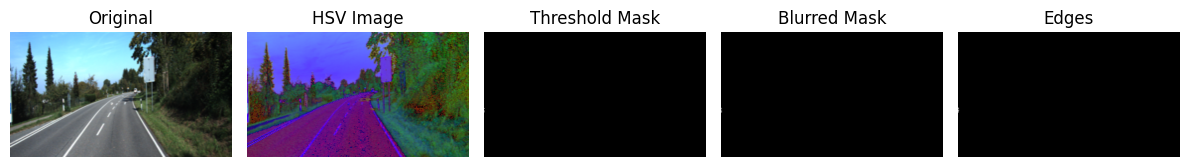

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Define the directories containing the lane detection images
lane_detection_dir = "/content/drive/MyDrive/final dataset/data_road_224/training/image_2"  # Update this path

# Function to recursively get image files in a directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_files.append(os.path.join(root, file))
    return image_files

# Preprocessing function for lane detection
def preprocess_lane_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None

    # Resize image for lane detection
    resized_image = cv2.resize(img, (640, 360))  # Adjust size as needed

    # Convert to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Thresholding to create a binary image for white lanes
    lower_white = np.array([0, 200, 200], dtype=np.uint8)  # Adjust this range
    upper_white = np.array([255, 255, 255], dtype=np.uint8)  # Adjust this range
    mask = cv2.inRange(hsv_image, lower_white, upper_white)

    # Apply Gaussian blur to reduce noise
    blurred_mask = cv2.GaussianBlur(mask, (5, 5), 0)

    # Perform edge detection
    edges = cv2.Canny(blurred_mask, 50, 150)

    # Define region of interest (optional)
    height, width = edges.shape
    mask_roi = np.zeros_like(edges)
    polygon = np.array([[(0, height), (width // 2, height // 2), (width, height)]], np.int32)
    cv2.fillPoly(mask_roi, polygon, 255)

    # Mask the edges image
    masked_edges = cv2.bitwise_and(edges, mask_roi)

    # Debugging: Show intermediate results
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 5, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title("HSV Image")
    plt.imshow(hsv_image)
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("Threshold Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.title("Blurred Mask")
    plt.imshow(blurred_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("Edges")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return masked_edges

# Function to display sample images after preprocessing
def display_preprocessed_samples(directory, title, num_images=6):
    image_files = get_image_files(directory)
    print(f"Found {len(image_files)} image(s) in {directory}")

    if not image_files:
        print(f"No image files found in {directory}")
        return

    num_images_to_display = min(num_images, len(image_files))
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(5 * num_images_to_display, 5))
    fig.suptitle(title)

    for i, img_path in enumerate(image_files[:num_images_to_display]):
        img_preprocessed = preprocess_lane_image(img_path)

        if img_preprocessed is not None:
            axs[i].imshow(img_preprocessed, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f"Preprocessed Sample {i+1}")

    plt.tight_layout()
    plt.show()

# Call the function to display preprocessed samples
display_preprocessed_samples(lane_detection_dir, "Lane Detection Samples")


In [ ]:
import os
import random
import shutil

# Paths to your original dataset and the directories for train and test
original_dataset_dir = '/content/drive/MyDrive/final dataset/data_road_224/training/image_2'  # Original dataset path
train_dir = '/content/drive/MyDrive/finaldataset/train'  # Training directory path
test_dir = '/content/drive/MyDrive/finaldataset/test'    # Testing directory path

# Create directories for training and testing
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get a list of all image files in the original dataset directory
files = [f for f in os.listdir(original_dataset_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the files for random splitting
random.shuffle(files)

# Split files into training (80%) and testing (20%)
split_index = int(0.8 * len(files))  # 80% for training
train_files = files[:split_index]
test_files = files[split_index:]

# Move files to their respective directories
for file in train_files:
    shutil.copy(os.path.join(original_dataset_dir, file), os.path.join(train_dir, file))

for file in test_files:
    shutil.copy(os.path.join(original_dataset_dir, file), os.path.join(test_dir, file))

print(f"Number of images in the training set: {len(train_files)}")
print(f"Number of images in the testing set: {len(test_files)}")

# Create class subfolders in train and test directories
os.makedirs(os.path.join(train_dir, 'lane_present'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'no_lane'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'lane_present'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'no_lane'), exist_ok=True)

# Function to assign images randomly to 'lane_present' and 'no_lane'
def assign_images_to_classes(directory):
    images = os.listdir(directory)

    for img in images:
        if img.lower().endswith((".png", ".jpg", ".jpeg")):
            # Randomly assign images to 'lane_present' or 'no_lane'
            class_name = random.choice(['lane_present', 'no_lane'])
            class_dir = os.path.join(directory, class_name)

            # Move the image to the respective class folder
            src = os.path.join(directory, img)
            dest = os.path.join(class_dir, img)
            shutil.move(src, dest)

# Assign images in train and test directories
assign_images_to_classes(train_dir)
assign_images_to_classes(test_dir)

print("Images have been assigned to class subfolders.")


Number of images in the training set: 231
Number of images in the testing set: 58
Images have been assigned to class subfolders.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input  # Specifically for ResNet-50

# Define the paths to the newly created split folders
train_split_dir = '/content/drive/MyDrive/dataset/train'
test_split_dir = '/content/drive/MyDrive/dataset/test'

# Image size for ResNet-50 (224x224)
image_size = (224, 224)
batch_size = 32

# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    preprocessing_function=preprocess_input  # Preprocessing function for ResNet-50
)

# Preprocessing for the test set (no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255,  # Only normalize pixel values
    preprocessing_function=preprocess_input  # Preprocessing function for ResNet-50
)

# Load and preprocess the training set
train_generator = train_datagen.flow_from_directory(
    train_split_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the testing set
test_generator = test_datagen.flow_from_directory(
    test_split_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

print("Training set:", train_generator.samples)
print("Testing set:", test_generator.samples)


Found 390 images belonging to 2 classes.
Found 191 images belonging to 2 classes.
Training set: 390
Testing set: 191


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the ResNet-50 model without the top classification layer
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model and add custom layers on top of ResNet-50
model = Sequential()
model.add(resnet50_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming 10 classes for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the preprocessed data
model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 468s 30s/step - accuracy: 0.5312 - loss: 1.6949 - val_accuracy: 0.4974 - val_loss: 75841.1797
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 359s 26s/step - accuracy: 0.5008 - loss: 0.8317 - val_accuracy: 0.5026 - val_loss: 45054.4180
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 336s 26s/step - accuracy: 0.5043 - loss: 0.7200 - val_accuracy: 0.4974 - val_loss: 725.1304
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 388s 26s/step - accuracy: 0.4990 - loss: 0.6917 - val_accuracy: 0.4974 - val_loss: 321.2382
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 337s 26s/step - accuracy: 0.5191 - loss: 0.6989 - val_accuracy: 0.4974 - val_loss: 31.7009
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 379s 25s/step - accuracy: 0.4868 - loss: 0.6950 - val_accuracy: 0.4974 - val_loss: 14.5966
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 334s 25s/step - accuracy: 0.5344 - loss: 0.6967 - val_accuracy: 0.4974 - val_loss: 1.1445
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 391s 26s/step - accuracy: 0.4672 - loss: 0.6926 - val_accuracy:

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the final test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.4656 - loss: 0.6935
Test Accuracy: 0.4660


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predicted labels for the test set
Y_true = test_generator.classes  # Actual labels
Y_pred = model.predict(test_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert probabilities to class predictions

# Print classification report (including F1-score)
print(classification_report(Y_true, Y_pred_classes, target_names=test_generator.class_indices.keys()))


6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step
              precision    recall  f1-score   support

lane_present       0.49      0.91      0.64        95
     no_lane       0.44      0.07      0.12        96

    accuracy                           0.49       191
   macro avg       0.46      0.49      0.38       191
weighted avg       0.46      0.49      0.38       191



In [ ]:
# Custom function to calculate X Error (example)
def calculate_x_error(Y_true, Y_pred_classes):
    # Replace this with your logic for X error
    return np.mean(np.abs(Y_true - Y_pred_classes))  # Example: Mean absolute difference

# Custom function to calculate Z Error (example)
def calculate_z_error(Y_true, Y_pred_classes):
    # Replace this with your logic for Z error
    return np.mean((Y_true - Y_pred_classes) ** 2)  # Example: Mean squared difference

# Calculate X Error and Z Error
x_error = calculate_x_error(Y_true, Y_pred_classes)
z_error = calculate_z_error(Y_true, Y_pred_classes)

print(f"X Error: {x_error:.4f}")
print(f"Z Error: {z_error:.4f}")


X Error: 0.5131
Z Error: 0.5131


In [ ]:
import time

# Measure time for a single batch
start_time = time.time()
model.predict(test_generator, steps=1)  # Predict on 1 batch
end_time = time.time()

# Calculate FPS (number of images processed in one second)
elapsed_time = end_time - start_time
num_images_in_batch = test_generator.batch_size
fps = num_images_in_batch / elapsed_time

print(f"FPS: {fps:.2f} frames per second")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
FPS: 5.77 frames per second
